In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import f1_score
import time

sys.path.insert(1, os.path.join(sys.path[0], "code/implementation"))
from layer_v2 import Layer
from neural_network_v2 import NeuralNetwork

In [3]:
def visualize_fit_of_regression(data_frame, neural, std):
    y = neural.predict(data_frame["x"])
    plt.scatter(data_frame["x"], y, c="red")
    plt.scatter(data_frame["x"], data_frame["y"], c="blue")
    plt.legend(["Prediction", "True"])
    return neural.calculate_cost(data_frame["x"], data_frame["y"]) * std["y"] ** 2

In [4]:
multimodal_train = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-training.csv"
)
multimodal_test = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-test.csv"
)
mean = multimodal_train.mean()
std = multimodal_train.std()
multimodal_train = (multimodal_train - mean) / std
multimodal_test = (multimodal_test - mean) / std

# Joke but works surprisingly well  

In [5]:
neural = NeuralNetwork(cost_function="mse")
neural.add_layer(Layer(1, 10, "relu"))
neural.add_layer(Layer(10, 20, "relu"))
neural.add_layer(Layer(20, 100, "relu"))
neural.add_layer(Layer(100, 1, "linear"))
mse = neural.train(multimodal_test["x"], multimodal_test["y"], max_num_epoch=1500, learning_rate=0.001)

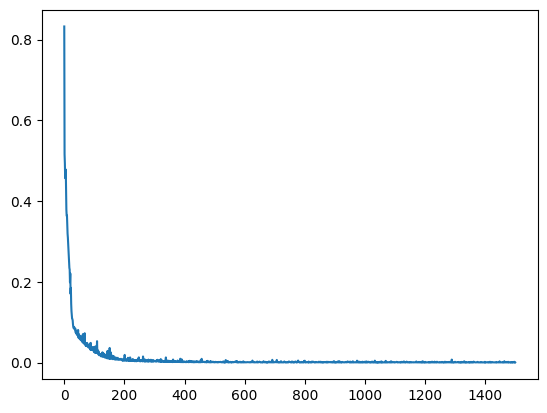

In [6]:
plt.plot(mse)

3.7861997579177413

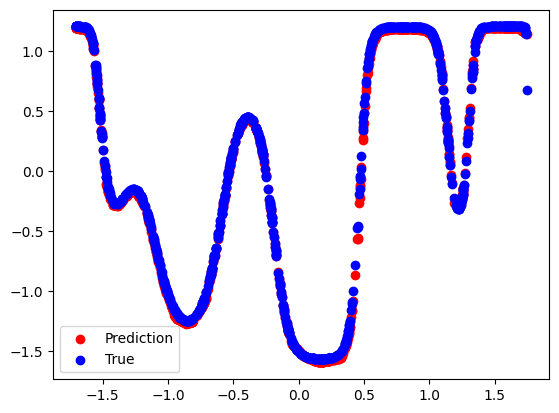

In [7]:
visualize_fit_of_regression(multimodal_test, neural, std)

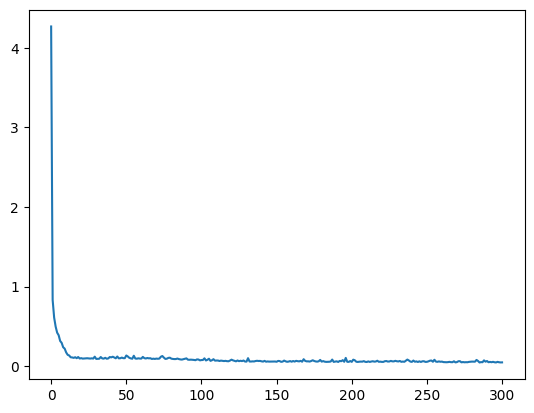

In [8]:
neural = NeuralNetwork(cost_function="mse")
neural.add_layer(Layer(1, 10, "relu"))
neural.add_layer(Layer(10, 10, "relu"))
neural.add_layer(Layer(10, 1, "linear"))
mse = neural.train(
    multimodal_test["x"], multimodal_test["y"], max_num_epoch=300, learning_rate=0.01
)
plt.plot(mse)

257.7151700684677

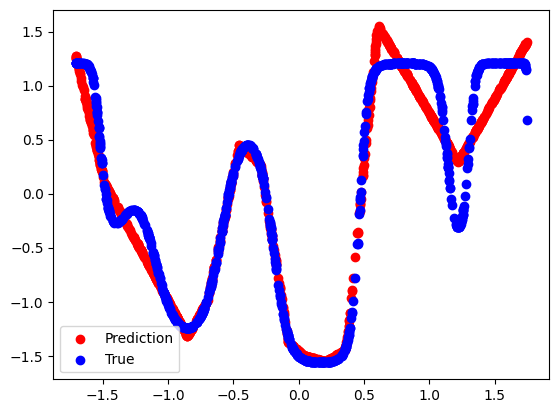

In [9]:
visualize_fit_of_regression(multimodal_test, neural, std)

In [10]:
activation_functions = ["relu", "sigmoid", "tanh", "linear", "leaky_relu"]
initialization_methods = [
    "normal",
    "uniform_xavier",
    "he",
    "normal_xavier",
    "uniform_minus_one_one",
    "uniform_zero_one",
]
number_of_repetition = 2 # 10

In [25]:
from collections import defaultdict 
df = pd.DataFrame(columns=["Initialization", "Activation", "Hidden Layers", "Cost", "Computation Time"])
after_epoch_dict = defaultdict(lambda: []) 

for initialization_method in initialization_methods:
    for activation in activation_functions:
        for _ in range(number_of_repetition):
            # One hidden layer creation
            one_hidden = NeuralNetwork(cost_function="mse")
            one_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            one_hidden.add_layer(Layer(10, 1, "linear"))

            # Two hidden layers creation
            two_hidden = NeuralNetwork(cost_function="mse")
            two_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(Layer(10, 1, "linear"))

            # Three hidden layers creation
            three_hidden = NeuralNetwork(cost_function="mse")
            three_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(Layer(10, 1, "linear"))

            # Training
            time_start = time.time()
            one_cost_after_epoch = one_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_first = time.time() - time_start
            two_cost_after_epoch = two_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_second = time.time() - time_start - time_first
            three_cost_after_epoch = three_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_third = time.time() - time_start - time_first - time_second

            # Testing
            one_hidden_test_cost = one_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )
            two_hidden_test_cost = two_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )
            three_hidden_test_cost = three_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )

            # Saving cost after training results
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "1",
                one_hidden_test_cost,
                time_first
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "2",
                two_hidden_test_cost,
                time_second
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "3",
                three_hidden_test_cost,
                time_third
            ]
            
            # Saving cost after epoch results
            after_epoch_dict[
                f"{initialization_method}/{activation}/1"
            ].append(one_cost_after_epoch)
            after_epoch_dict[
                f"{initialization_method}/{activation}/2"
            ].append(two_cost_after_epoch)
            after_epoch_dict[
                f"{initialization_method}/{activation}/3"
            ].append(three_cost_after_epoch)
    print(f"Initialization method {initialization_method} done")

Initialization method normal done
Initialization method uniform_xavier done
Initialization method he done
Initialization method normal_xavier done
Initialization method uniform_minus_one_one done
Initialization method uniform_zero_one done


In [26]:
df 

,Initialization,Activation,Hidden Layers,Cost,Computation Time
0,normal,relu,1,0.433260,0.317569
1,normal,relu,2,0.400265,0.652412
2,normal,relu,3,0.096249,1.120421
3,normal,relu,1,0.466776,0.228198
4,normal,relu,2,0.357758,0.616163
...,...,...,...,...,...
175,uniform_zero_one,leaky_relu,2,1.065715,0.588216
176,uniform_zero_one,leaky_relu,3,0.938268,1.063753
177,uniform_zero_one,leaky_relu,1,0.559788,0.237751
178,uniform_zero_one,leaky_relu,2,0.529350,0.671695


Text(0.5, 1.0, 'Cost of Neural Network with Different Activation Functions and Hidden Layers with He Initialization')

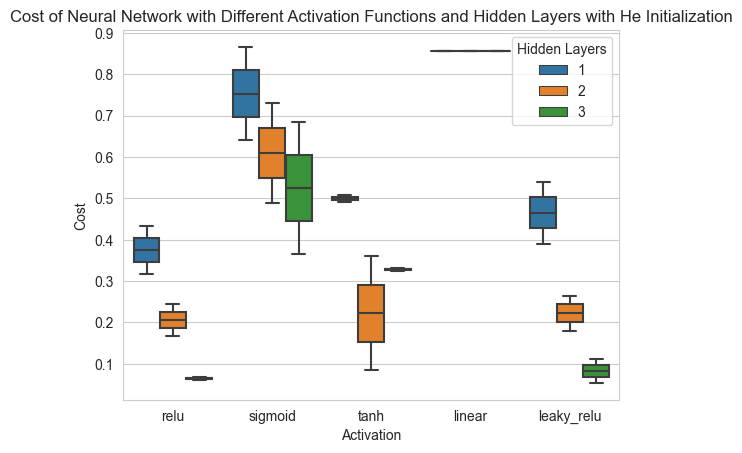

In [27]:
import seaborn as sns
sns.set_style("whitegrid")
df_he = df[df["Initialization"] == "he"]
sns.boxplot(x="Activation", y="Cost", data=df_he, hue="Hidden Layers")
plt.title(
    "Cost of Neural Network with Different Activation Functions and Hidden Layers with He Initialization"
)

In [28]:
after_epoch_dict

defaultdict(<function __main__.<lambda>()>,
            {'normal/relu/1': [[5.031864082687659,
               5.031864082687659,
               4.426672603520255,
               3.8704963078798222,
               3.363708670325204,
               2.90621631263874,
               2.4974174456454907,
               2.1362987423998705,
               1.8212070485632808,
               1.5501905189913137,
               1.3208778346645136,
               1.130691702235906,
               0.9766780287857988,
               0.8555005775689537,
               0.7634836068689433,
               0.6964325671381784,
               0.6496800523100995,
               0.6192979399538492,
               0.6015283996298165,
               0.5922207166761203,
               0.5896574411853993,
               0.592075331216792,
               0.5977704175725639,
               0.605236209513016,
               0.6131983370588042,
               0.6206258965418799,
               0.6267541721294668,
   

Text(0, 0.5, 'MSE')

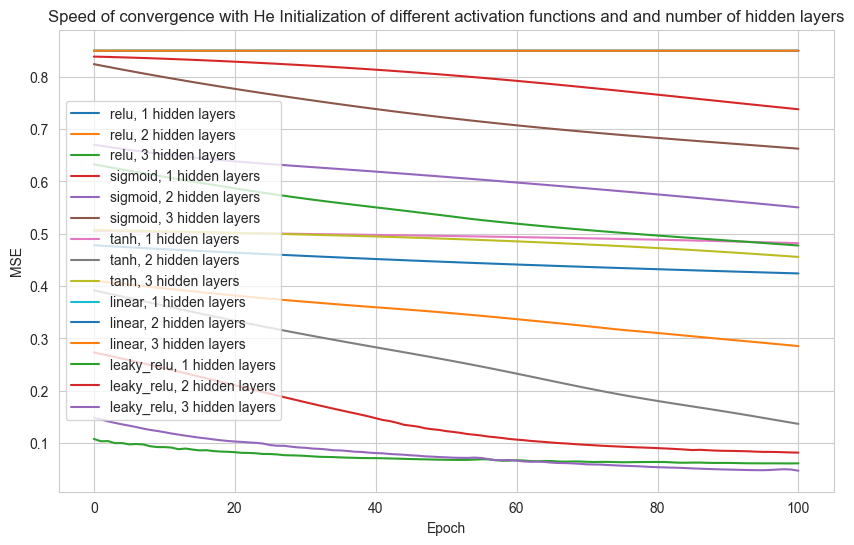

In [30]:
plt.figure(figsize=(10, 6))
for key, value in after_epoch_dict.items():
    key  = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers"
    if key[0] == "uniform_xavier":
        plt.plot(np.mean(value, axis=0)[100:], label=label)
plt.legend()
plt.title("Speed of convergence with He Initialization of different activation functions and and number of hidden layers")
plt.xlabel("Epoch")
plt.ylabel("MSE")